In [1]:
import os
import shutil
import unittest
from catvae.trainer import LightningCatVAE
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import torch
import argparse
import seaborn as sns

# Simulate data

In [2]:
np.random.seed(0)
k = 10
sims = multinomial_bioms(k=k, D=50, N=500, M=100000)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

sims['tree'].write('basis.nwk')

'basis.nwk'

In [19]:
train

50 x 400 <class 'biom.table.Table'> with 20000 nonzero entries (100% dense)

In [3]:
train

50 x 400 <class 'biom.table.Table'> with 20000 nonzero entries (100% dense)

# Train model

In [4]:
from pytorch_lightning.profiler import AdvancedProfiler

output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'test.biom',
    '--val-biom', 'valid.biom',
    '--basis', 'basis.nwk',
    '--output-directory', output_dir,
    '--epochs', '5000',
    '--batch-size', '50',
    '--steps-per-batch', '50',
    '--encoder-depth', '1',
    '--num-workers', '20',
    '--scheduler', 'none',
    '--learning-rate', '1e-3',
    '--n-latent', str(k),
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
parser = LightningCatVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningCatVAE(args)
model.set_eigs(sims['eigvectors'], sims['eigs'])
profiler = AdvancedProfiler()


trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=1,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type         | Params
---------------------------------------
0 | model | LinearCatVAE | 3 K   


/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

In [5]:
%load_ext tensorboard

In [6]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 23638), started 0:35:33 ago. (Use '!kill 23638' to kill it.)

# Evaluate the model

In [12]:
!ls lightning_logs/version_34/checkpoints

'epoch=28.ckpt'


In [8]:
torch.__version__

'1.7.0.dev20200909'

In [3]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_34/checkpoints'
path = f'{checkpoint_dir}/epoch=28.ckpt'
model = LightningCatVAE.load_from_checkpoint(path).cuda()

(0.8320137510257484, 1.0509065388387588e-302)


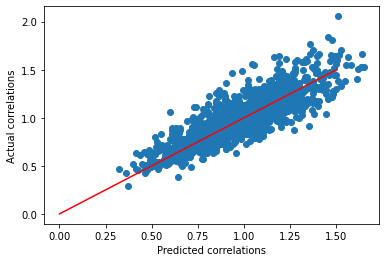

In [7]:
#W = model.model.get_loadings()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.model.decoder.weight.detach().cpu().numpy()
V = model.model.encoder.weight.detach().cpu().numpy()

X = torch.Tensor(np.array(train.matrix_data.todense()).T).cuda()
d = X.shape[1] - 1
Y = torch.Tensor(np.eye(d) @ sims['Psi']).cuda()

estD = torch.exp(model.model.variational_logvars).detach().cpu().numpy()
est_sigma = (torch.exp(model.model.log_sigma_sq)).detach().cpu().numpy()

# Option 1 : will definitely work
#u, s, v = np.linalg.svd(V)
#A = np.diag(s)
#W = W @ A
# Option 2 : WIP
z = model.to_latent(Y).detach().cpu().numpy()
u, s, v = np.linalg.svd(z)
A = np.diag(s)
W = W @ A

d_estW = pdist(W)
dW = pdist(sims['W'])
# we appear to be off by a factor of 2 -- where is this coming from?
plt.scatter(dW, d_estW)
plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

In [30]:
est_sigma

array(0.07265583, dtype=float32)

In [11]:
s, np.sqrt(est_sigma)

NameError: name 's' is not defined

In [ ]:
eigvals = (W**2).sum(axis=0)

np.sort(est_sigma / eigvals)

In [ ]:
plt.scatter(np.sort(est_sigma / eigvals), np.sort(estD))

In [ ]:
np.linalg.pinv(true_cov) @ est_cov

In [ ]:
np.diag(sims['W'].T @ sims['W'])

In [ ]:
np.diag(W.T @ W)

In [ ]:
eigvals = (W**2).sum(axis=0)
Weig = W / np.sqrt(eigvals)

In [ ]:
np.round(Weig.T @ Weig, 2)

In [ ]:
Wu, Ws, Wv = np.linalg.svd(W)
k = W.shape[1]
Wu = Wu[:, :k]
Ws = Ws[:k]
Wv = Wv[:k, :]

In [ ]:
np.linalg.norm(Weig.T @ Weig - np.eye(Weig.shape[-1]))

In [ ]:
Ws

In [ ]:
eigvals = np.sqrt(np.sort(eigvals)[::-1])

In [ ]:
np.sqrt(np.sum((eigvals - Ws)**2))

In [ ]:
sims['sigma']

In [ ]:
torch.exp(model.model.log_sigma_sq)

In [ ]:
model.model.log_sigma_sq

In [ ]:
torch.sqrt(sims['sigma'] / torch.exp(model.model.log_sigma_sq))

In [ ]:
est_sigma = (torch.exp(model.model.log_sigma_sq)).detach().cpu().numpy()
true_sigma = sims['sigma']

In [ ]:
np.sort(sims['eigs'])[::-1]

In [ ]:
eigvals

In [ ]:
np.sqrt(est_sigma), true_sigma